## Import libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
import csv
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
tf.__version__

'2.2.0'

## Load Dataset

### Mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and preprocess

In [5]:
dataframe=pd.read_csv("/content/drive/My Drive/Colab Notebooks/course_tensorflow2.0/ejercicios/datos/googleplaystore_user_reviews.csv")

In [6]:
dataframe.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [7]:
#Remove the columns that we are not interested in
dataframe=dataframe.drop(["App","Sentiment_Polarity","Sentiment_Subjectivity"],axis=1)

In [8]:
#Delete the rows that have null data
dataframe=dataframe.dropna()

In [9]:
dataframe.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


In [10]:
dataframe["Sentiment"].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [11]:
#function to clean data
def clean(sentence):
  sentence=re.sub("[^a-zA-z]"," ",sentence)
  sentence=re.sub("\s+[a-zA-Z]\s+"," ",sentence)
  sentence=re.sub("\s+"," ",sentence)
  sentence=sentence.lower()
  words = sentence.split()
  filtered_words = [word for word in words if word not in stopwords.words('english')]
  return " ".join(filtered_words)


In [12]:
dataframe["Translated_Review"]=dataframe["Translated_Review"].apply( lambda x:clean(x))

In [13]:
dataframe.tail()

,Translated_Review,Sentiment
64222,ads older many agents much owner posted detail...,Positive
64223,photos posted portal load fit purpose sure sto...,Positive
64226,dumb app wanted post property rent give option...,Negative
64227,property business got link sms happy performan...,Positive
64230,useless app searched flats kondapur hyderabad ...,Negative


In [14]:
#convert labels to number
dataframe["Sentiment"]=dataframe["Sentiment"].replace(["Positive","Negative","Neutral"],[0,1,2])

In [15]:
dataframe

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,0
1,help eating healthy exercise regular basis,0
3,works great especially going grocery store,0
4,best idea us,0
5,best way,0
...,...,...
64222,ads older many agents much owner posted detail...,0
64223,photos posted portal load fit purpose sure sto...,0
64226,dumb app wanted post property rent give option...,1
64227,property business got link sms happy performan...,0


## tokenization

In [16]:
num_words=20000
maxlen=100

In [17]:
# split training and test datasets
sentences=list(dataframe["Translated_Review"])
labels=np.array(dataframe["Sentiment"])
train_sentences=sentences[:30000]
test_sentences=sentences[30000:]
train_labels=labels[:30000]
test_labels=labels[30000:]

In [18]:
#tokenization
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index
sequences=tokenizer.texts_to_sequences(train_sentences)
sequences=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)

test_sequences=tokenizer.texts_to_sequences(test_sentences)
test_sequences=tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=maxlen)




In [19]:
test_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   13,   44,  670,   69,  127, 1137,
       2402,   63,    5,    3,   39,    8,  690,   66,  723,  130,  377,
        595], dtype=int32)

In [20]:
sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    3,  590, 3275,
        132, 1204,  132,  914,   25,  624,  272,   57,   21,   25, 4076,
        212], dtype=int32)

## build the model

In [45]:
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(num_words,64,input_length=maxlen),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.Dense(3,activation="softmax")
])

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           1280000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 1,494,275
Trainable params: 1,494,275
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile( optimizer="Rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [48]:
sequences.shape

(30000, 100)

In [49]:
train_labels.shape

(30000,)

## Training

In [44]:
history=model.fit(sequences,train_labels, validation_data=(test_sequences,test_labels) ,batch_size=100,epochs=10)

Epoch 1/6
300/300 [==============================] - 8s 28ms/step - loss: 0.5130 - accuracy: 0.7962 - val_loss: 0.3573 - val_accuracy: 0.8710
Epoch 2/6
300/300 [==============================] - 8s 25ms/step - loss: 0.2375 - accuracy: 0.9244 - val_loss: 0.3276 - val_accuracy: 0.8865
Epoch 3/6
300/300 [==============================] - 8s 26ms/step - loss: 0.1768 - accuracy: 0.9470 - val_loss: 0.3159 - val_accuracy: 0.8888
Epoch 4/6
300/300 [==============================] - 8s 26ms/step - loss: 0.1528 - accuracy: 0.9546 - val_loss: 0.3359 - val_accuracy: 0.8886
Epoch 5/6
300/300 [==============================] - 8s 26ms/step - loss: 0.1346 - accuracy: 0.9600 - val_loss: 0.3355 - val_accuracy: 0.8909
Epoch 6/6
300/300 [==============================] - 8s 26ms/step - loss: 0.1193 - accuracy: 0.9651 - val_loss: 0.3548 - val_accuracy: 0.8899


## Plotting


Text(0, 0.5, 'accuracy')

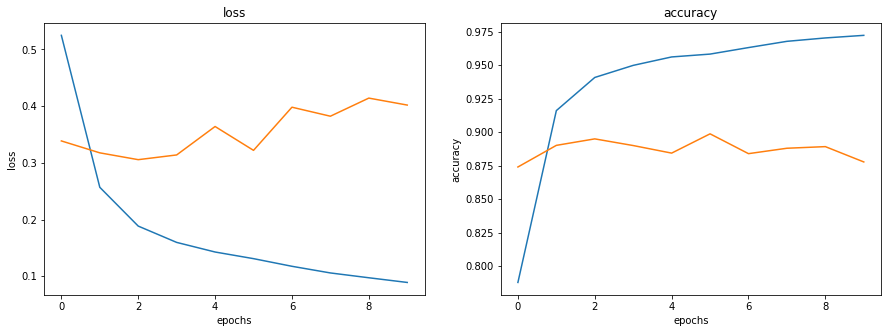

In [32]:
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots( nrows=1,ncols=2,figsize=(15,5) )
ax1.plot(history.epoch,history.history["loss"])
ax1.plot(history.epoch,history.history["val_loss"])
ax1.set_title('loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax2.plot(history.epoch,history.history["accuracy"])
ax2.plot(history.epoch,history.history["val_accuracy"])
ax2.set_title('accuracy')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")